In [1]:
from __future__ import division, absolute_import, print_function
%matplotlib inline

In [2]:
import time
import numpy as np

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [4]:
!echo $CUDA_VISIBLE_DEVICES

0


## Get the data

This is the data from the MADELON dataset http://archive.ics.uci.edu/ml/datasets/madelon

In [5]:
!ls dataset/MADELON

madelon.param	   madelon_train.data	 madelon_valid.data
madelon_test.data  madelon_train.labels


In [6]:
data = np.loadtxt("dataset/MADELON/madelon_train.data", dtype=np.int32)
validation_data = np.loadtxt("dataset/MADELON/madelon_valid.data", dtype=np.int32)
print(data.shape)
print(validation_data.shape)

(2000, 500)
(600, 500)


### Subset the data to exclude irrelevant features

In [7]:
#relevant_features = np.array([339,443,473,49,379,476,242,106,319,29,452,434,129,282,454,154,337,65,494])
#relevant_features = np.array([ 29, 49, 65, 106, 129, 154, 242, 282, 319, 337, 339, 379, 434, 443, 452, 454, 456, 473, 476, 494])
relevant_features = np.array([18, 29, 45, 49, 65, 78, 80, 106, 122, 129, 136, 148, 154, 155, 189, 242, 254, 282, 302, 315, 319, 323, 337, 339, 366, 367, 379, 402, 403, 428, 434, 438, 443, 452, 454, 456, 470, 473, 476, 494])
relevant_features = relevant_features - 1 # Convert 1 indexed to 0 indexed
data = data[:, relevant_features]
validation_data = validation_data[:, relevant_features]
print(data.shape)
print(validation_data)

(2000, 40)
[[493 490 526 ..., 454 538 259]
 [466 491 490 ..., 439 429 534]
 [516 479 495 ..., 494 517 495]
 ..., 
 [510 504 471 ..., 417 514 368]
 [458 468 498 ..., 501 521 638]
 [540 491 529 ..., 489 398 694]]


In [8]:
labels = np.loadtxt("dataset/MADELON/madelon_train.labels", dtype=np.int32)
validation_labels= np.loadtxt("dataset/madelon_valid.labels", dtype=np.int32)
print(labels.shape)
print(labels)

(2000,)
[-1 -1 -1 ..., -1  1  1]


### Normalize the data by getting using average and stdev

In [9]:
def get_average_and_stdev(input_array):
    avg = np.average(input_array, axis=0)
    return avg, np.std(input_array, axis=0)

In [10]:
def normalize(input_array, avg, stdev):
    avgremoved = input_array - avg[None,:]
    return avgremoved/stdev

#### Note that validation data is normalized using original bias and stdev

In [11]:
avg, stdev = get_average_and_stdev(data)
normalized = normalize(data, avg, stdev)
normalized_validation = normalize(validation_data, avg, stdev)
validation_pos_indices = np.nonzero(validation_labels == 1)[0]
normalized_validation_pos=normalize(validation_data[validation_pos_indices], avg, stdev)
print(avg.shape)
print(normalized.shape)
print(normalized_validation.shape)

(40,)
(2000, 40)
(600, 40)


In [12]:
background_indices = np.nonzero(labels == -1)[0]
#print(background_indices.shape)
#print(background_indices)
mean_bg_feature_values = np.average(normalized[background_indices], axis=0)
print(mean_bg_feature_values)
#print(mean_bg_feature_values.shape)

[ 0.00614864 -0.00357137 -0.03611492 -0.11847695  0.15032661 -0.0121204
  0.0161474  -0.12626289 -0.03262733 -0.12675752 -0.01211058  0.01422029
  0.03378346  0.02115268  0.01560584 -0.21782664  0.02007631  0.03363522
 -0.03333143 -0.01496712 -0.00469233 -0.01324135  0.15167207  0.12178815
 -0.02155806  0.00988718 -0.11596197  0.01144217  0.01038823  0.00526089
  0.02981902  0.00995075  0.11435599 -0.01160078  0.0955404   0.0064516
  0.0054648   0.11207091 -0.21993314  0.09505615]


In [13]:
print(np.std(normalized, axis=0))

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.]


In [14]:
from sklearn.externals import joblib
classifier = joblib.load('GaussianClassifier_Madelon_20Best_20Random_C1_G0_1.pkl')

In [15]:
import ssvmimp.imp_scores_helper
reload(ssvmimp.imp_scores_helper)
from ssvmimp.imp_scores_helper import ImportanceScoresHelper
impscoreshelper = ImportanceScoresHelper(
    classifier, 0.1,
    normalized, 
    labels, use_csr=False)

start = time.time()
impscores_bgref, avggrad_bgref =\
    impscoreshelper.get_feature_contribs_using_average_gradient_from_reference(
                normalized_validation,
                reference_to_use=np.array([mean_bg_feature_values for x in
                                            range(normalized_validation.shape[0])]),
                numsteps=10)
print("Importance scores computed in:", round(time.time() - start, 2), "s")
print(impscores_bgref)
print(avggrad_bgref.shape)
final_importance_scores = np.sum(np.abs(impscores_bgref), axis=0)
#final_importance_scores = np.sum(impscores_bgref, axis=0)
print(final_importance_scores)

Support vector shape is (1946, 40)
CSR support vector count is 77840
Starting average gradient calculation for  100 th point
Starting average gradient calculation for  200 th point
Starting average gradient calculation for  300 th point
Starting average gradient calculation for  400 th point
Starting average gradient calculation for  500 th point
Starting average gradient calculation for  600 th point
Avg grad computed in: 2.49 s
Importance scores computed in: 2.49 s
[[ 0.0103794   0.05131101  0.05277319 ...,  0.07177307  0.14186705
   0.0458339 ]
 [ 0.0979523  -0.1473789  -0.03262407 ...,  0.16446169 -0.24355774
  -0.04943179]
 [-0.095507    0.00262352 -0.02073799 ..., -0.01321241  0.1320412
   0.00592892]
 ..., 
 [-0.08586931  0.02277374 -0.10441675 ...,  0.38357454  0.239219
   0.24600292]
 [-0.03091328  0.12421461 -0.00272781 ..., -0.05412791  0.18661857
  -0.0147649 ]
 [ 0.17195364 -0.11055832  0.16642481 ..., -0.00113026 -0.24829633
  -0.17913591]]
(600, 40)
[  44.74644541   59.8

In [16]:
sorted_indices = np.argsort(final_importance_scores)
print(sorted_indices)

[13 14 28 11  6 29 19 27 18 25 39 21 35 31 36 34 30 12  0 17  2  5 16  7  8
 33 20  9  4 23 22  1 10 32 37 24 26  3 15 38]


(array([ 13.,   4.,   7.,   8.,   4.,   0.,   0.,   1.,   1.,   2.]),
 array([  26.64091664,   35.02341293,   43.40590922,   51.78840551,
          60.1709018 ,   68.55339809,   76.93589438,   85.31839067,
          93.70088696,  102.08338325,  110.46587954]),
 <a list of 10 Patch objects>)

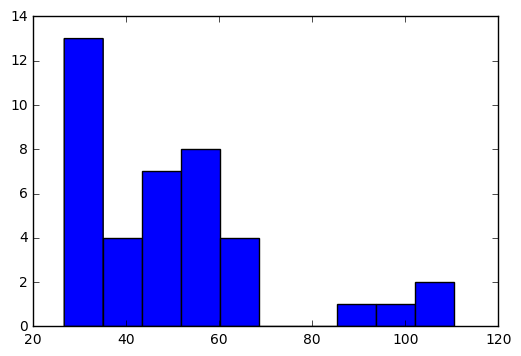

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.hist(final_importance_scores)

In [18]:
relevant_features

array([ 17,  28,  44,  48,  64,  77,  79, 105, 121, 128, 135, 147, 153,
       154, 188, 241, 253, 281, 301, 314, 318, 322, 336, 338, 365, 366,
       378, 401, 402, 427, 433, 437, 442, 451, 453, 455, 469, 472, 475, 493])

In [19]:
print(relevant_features[sorted_indices])

[154 188 402 147  79 427 314 401 301 366 493 322 455 437 469 453 433 153
  17 281  44  77 253 105 121 451 318 128  64 338 336  28 135 442 472 365
 378  48 241 475]


In [20]:
set_to_test = set([ 29, 49, 65, 106, 129, 154, 242, 282, 319, 337, 339, 379, 434, 443, 452, 454, 456, 473, 476, 494])
count = 0
for a_feat in relevant_features[sorted_indices][-10:]:
    if (a_feat+1) in set_to_test:
        count += 1
print(count)

8


In [21]:
b = np.array([ 29, 49, 65, 106, 129, 154, 242, 282, 319, 337, 339, 379, 434, 443, 452, 454, 456, 473, 476, 494]) - 1
print(b)

[ 28  48  64 105 128 153 241 281 318 336 338 378 433 442 451 453 455 472
 475 493]
